This notebook creates plots to compare different seq_length values: median NSE vs. seq_length and boxplots of NSE across seq_length.

In [9]:
import pandas as pd
from pathlib import Path
import re
import matplotlib.pyplot as plt

# Base directory containing experiment runs
runs_dir = Path("./runs")

seq_lengths = []
median_nse = []

In [10]:
# Extract seq_length from folder name
pattern = re.compile(r"5_uy_gauges_30_epochs_seq_(\d+)_hidden")

In [11]:
for run_dir in runs_dir.iterdir():
    if not run_dir.is_dir():
        continue

    match = pattern.search(run_dir.name)
    if match is None:
        continue

    seq = int(match.group(1))

    metrics_file = (
        run_dir
        / "validation"
        / "model_epoch030"
        / "validation_metrics.csv"
    )

    if not metrics_file.exists():
        continue

    df = pd.read_csv(metrics_file)

    if "NSE" not in df.columns:
        continue

    seq_lengths.append(seq)
    median_nse.append(df["NSE"].median())

# Build dataframe and sort by seq_length
plot_df = (
    pd.DataFrame({
        "seq_length": seq_lengths,
        "median_nse": median_nse
    })
    .sort_values("seq_length")
)

In [12]:
plot_df.head()

,seq_length,median_nse
15,7,0.399576
17,14,0.507320
9,21,0.624975
3,28,0.664284
26,35,0.510357


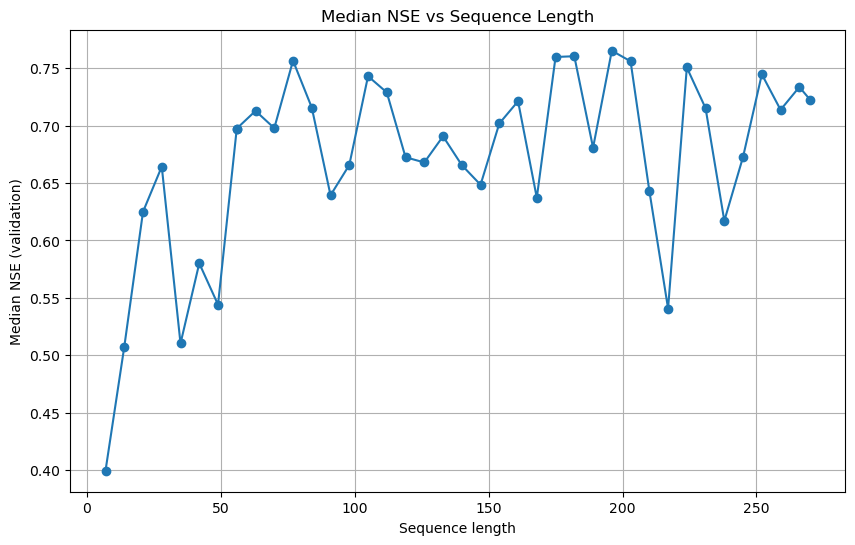

In [13]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(plot_df["seq_length"], plot_df["median_nse"], marker="o")
plt.xlabel("Sequence length")
plt.ylabel("Median NSE (validation)")
plt.title("Median NSE vs Sequence Length")
plt.grid(True)
plt.show()

# Boxplots

In [14]:
# Prepare storage
all_results = []  # for individual basin NSE values
median_results = []  # for median NSE per seq_length

for run_dir in runs_dir.iterdir():
    if not run_dir.is_dir():
        continue

    match = pattern.search(run_dir.name)
    if match is None:
        continue

    seq = int(match.group(1))

    metrics_file = run_dir / "validation" / "model_epoch030" / "validation_metrics.csv"
    if not metrics_file.exists():
        continue

    df = pd.read_csv(metrics_file)
    if "NSE" not in df.columns:
        continue

    # --- Store individual NSE values per basin ---
    for _, row in df.iterrows():
        all_results.append({
            "seq_length": seq,
            "basin": row["basin"],  # or "gauge_id" if that's the column name
            "NSE": row["NSE"]
        })

    # --- Compute median NSE per run ---
    median_results.append({
        "seq_length": seq,
        "median_NSE": df["NSE"].median()
    })

# --- Convert to DataFrames ---
individual_df = pd.DataFrame(all_results)  # individual NSE per basin
median_df = pd.DataFrame(median_results).sort_values("seq_length")  # median per seq_length


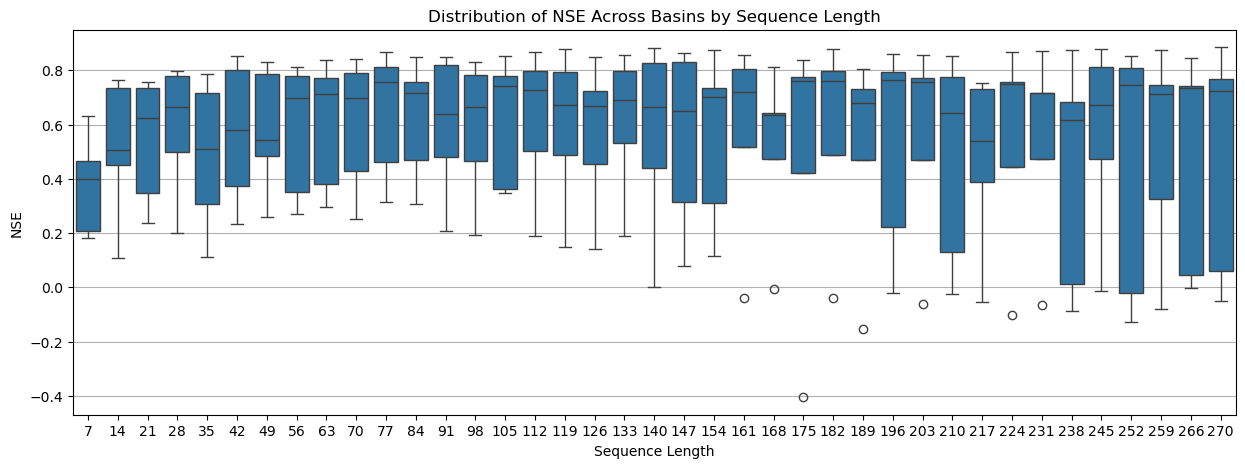

In [15]:
import seaborn as sns


plt.figure(figsize=(15, 5))

sns.boxplot(
    data=individual_df,
    x="seq_length",
    y="NSE"
)

plt.xlabel("Sequence Length")
plt.ylabel("NSE")
plt.title("Distribution of NSE Across Basins by Sequence Length")
plt.grid(True, axis='y')
plt.show()